<a href="https://colab.research.google.com/github/dh646956164/CS_project/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
df_cleaned = df.dropna(subset=['Comment Classification'])
df_cleaned['Comment Classification'] = df_cleaned['Comment Classification'].astype(str).str.split(', ')

mlb = MultiLabelBinarizer()
label_data_cleaned = mlb.fit_transform(df_cleaned['Comment Classification'])
label_df_cleaned = pd.DataFrame(label_data_cleaned, columns=mlb.classes_)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(df_cleaned['Comment Body'], label_df_cleaned, test_size=0.2, random_state=42)

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True  # Explicit truncation
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values)
test_labels = torch.tensor(y_test_cleaned.values)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. 使用BERT进行多标签分类的模型定义和训练
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        # Calling model without labels
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = outputs[0]

        # Manually computing the loss
        loss_fn = torch.nn.BCEWithLogitsLoss()
        loss = loss_fn(logits, labels.float())

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})


# 4. 模型评估
model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0].detach().cpu().numpy()
    labels = labels.cpu().numpy()
    predictions.append(logits)
    true_labels.append(labels)

# ... (您可以在这里进一步处理预测结果，例如计算性能指标)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-5c0f14b93dac>", line 7, in <cell line: 7>
    from transformers import BertTokenizer, BertForSequenceClassification, AdamW
ModuleNotFoundError: No module named 'transformers'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 281, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/

Custom TB Handler failed, unregistering


# 新段落

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
df_cleaned = df.dropna(subset=['Comment Classification'])
df_cleaned['Comment Classification'] = df_cleaned['Comment Classification'].astype(str).str.split(', ')

mlb = MultiLabelBinarizer()
label_data_cleaned = mlb.fit_transform(df_cleaned['Comment Classification'])
label_df_cleaned = pd.DataFrame(label_data_cleaned, columns=mlb.classes_)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(df_cleaned['Comment Body'], label_df_cleaned, test_size=0.2, random_state=42)

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values)
test_labels = torch.tensor(y_test_cleaned.values)

# 3. DataLoader Preparation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Model Preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


# 5. Model Training
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels.float())  # Ensure labels are float type
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {avg_train_loss:.3f}")

# 6. Model Evaluation
model.eval()
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(logits)

# Convert logits to labels
pred_labels = [(np.array(pred) > 0).astype(int) for pred in predictions]

# 7. Compute Metrics
true_labels_flat = y_test_cleaned.values
print("Classification Report:")
print(classification_report(true_labels_flat, pred_labels, target_names=mlb.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 46/46 [00:30<00:00,  1.51it/s, loss=20.9]


Epoch 1 - Training loss: 0.454


Epoch 2: 100%|██████████| 46/46 [00:28<00:00,  1.60it/s, loss=5.64]


Epoch 2 - Training loss: 0.245


Epoch 3: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=2.7]


Epoch 3 - Training loss: 0.176


Epoch 4: 100%|██████████| 46/46 [00:29<00:00,  1.58it/s, loss=1.7]


Epoch 4 - Training loss: 0.147


Epoch 5: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=1.23]


Epoch 5 - Training loss: 0.134
Classification Report:
                                    precision    recall  f1-score   support

Algorithmic Efficiency/Performance       0.00      0.00      0.00         1
                   Code Complexity       0.00      0.00      0.00        14
           Code Style & Formatting       0.00      0.00      0.00        21
              Compatibility Issues       0.00      0.00      0.00         4
        Data & Resource Management       0.00      0.00      0.00         1
             Depreciated Functions       0.00      0.00      0.00         1
                     Documentation       0.00      0.00      0.00        21
                       Duplication       0.00      0.00      0.00         2
                      Element Type       0.00      0.00      0.00         2
                    Execution Time       0.00      0.00      0.00         1
              Feature Completeness       0.00      0.00      0.00         1
                    Function Call

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
df_cleaned = df.dropna(subset=['Comment Classification'])
df_cleaned['Comment Classification'] = df_cleaned['Comment Classification'].astype(str).str.split(', ')

mlb = MultiLabelBinarizer()
label_data_cleaned = mlb.fit_transform(df_cleaned['Comment Classification'])
label_df_cleaned = pd.DataFrame(label_data_cleaned, columns=mlb.classes_)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(df_cleaned['Comment Body'], label_df_cleaned, test_size=0.2, random_state=42)

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values)
test_labels = torch.tensor(y_test_cleaned.values)

# 3. DataLoader Preparation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Model Preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
model.config.hidden_dropout_prob = 0.5  # Add dropout
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Add learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader) * epochs)

# 5. Model Training
epochs = 10  # Increased epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels.float())
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update learning rate
        scheduler.step()

        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {avg_train_loss:.3f}")

# 6. Model Evaluation
model.eval()
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(logits)

# Adjust decision threshold
threshold = 0.3
pred_labels = [(np.array(pred) > threshold).astype(int) for pred in predictions]

# 7. Compute Metrics
true_labels_flat = y_test_cleaned.values
print("Classification Report:")
print(classification_report(true_labels_flat, pred_labels, target_names=mlb.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=22.5]


Epoch 1 - Training loss: 0.488


Epoch 2: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=6.47]


Epoch 2 - Training loss: 0.281


Epoch 3: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=3.24]


Epoch 3 - Training loss: 0.211


Epoch 4: 100%|██████████| 46/46 [00:29<00:00,  1.58it/s, loss=2.11]


Epoch 4 - Training loss: 0.183


Epoch 5: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=1.59]


Epoch 5 - Training loss: 0.173


Epoch 6: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=1.31]


Epoch 6 - Training loss: 0.171


Epoch 7: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=1.13]


Epoch 7 - Training loss: 0.171


Epoch 8: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=0.985]


Epoch 8 - Training loss: 0.171


Epoch 9: 100%|██████████| 46/46 [00:29<00:00,  1.59it/s, loss=0.875]


Epoch 9 - Training loss: 0.171


Epoch 10: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, loss=0.787]


Epoch 10 - Training loss: 0.171
Classification Report:
                                    precision    recall  f1-score   support

Algorithmic Efficiency/Performance       0.00      0.00      0.00         1
                   Code Complexity       0.00      0.00      0.00        14
           Code Style & Formatting       0.00      0.00      0.00        21
              Compatibility Issues       0.00      0.00      0.00         4
        Data & Resource Management       0.00      0.00      0.00         1
             Depreciated Functions       0.00      0.00      0.00         1
                     Documentation       0.00      0.00      0.00        21
                       Duplication       0.00      0.00      0.00         2
                      Element Type       0.00      0.00      0.00         2
                    Execution Time       0.00      0.00      0.00         1
              Feature Completeness       0.00      0.00      0.00         1
                    Function Cal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344:

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
df_cleaned = df.dropna(subset=['Comment Classification'])
df_cleaned['Comment Classification'] = df_cleaned['Comment Classification'].astype(str).str.split(', ')

mlb = MultiLabelBinarizer()
label_data_cleaned = mlb.fit_transform(df_cleaned['Comment Classification'])
label_df_cleaned = pd.DataFrame(label_data_cleaned, columns=mlb.classes_)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(df_cleaned['Comment Body'], label_df_cleaned, test_size=0.2, random_state=42)

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values)
test_labels = torch.tensor(y_test_cleaned.values)

# 3. DataLoader Preparation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Custom Model Preparation with additional Fully Connected Layers
class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.classifier[-1].out_features), labels.view(-1, self.classifier[-1].out_features).float())
        return loss, logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(num_labels=len(mlb.classes_))
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Add learning rate scheduler
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# 5. Model Training
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update learning rate
        scheduler.step()

        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {avg_train_loss:.3f}")

# 6. Model Evaluation
model.eval()
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)

    with torch.no_grad():
        loss, logits = model(input_ids, attention_mask=attention_mask)
    logits = logits.detach().cpu().numpy()
    predictions.extend(logits)

# Adjust decision threshold
threshold = 0.3
pred_labels = [(np.array(pred) > threshold).astype(int) for pred in predictions]

# 7. Compute Metrics
true_labels_flat = y_test_cleaned.values
print("Classification Report:")
print(classification_report(true_labels_flat, pred_labels, target_names=mlb.classes_))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 46/46 [00:31<00:00,  1.46it/s, loss=26.1]


Epoch 1 - Training loss: 0.566


Epoch 2: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=7.76]


Epoch 2 - Training loss: 0.338


Epoch 3: 100%|██████████| 46/46 [00:29<00:00,  1.55it/s, loss=3.29]


Epoch 3 - Training loss: 0.214


Epoch 4: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=1.89]


Epoch 4 - Training loss: 0.164


Epoch 5: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=1.33]


Epoch 5 - Training loss: 0.145


Epoch 6: 100%|██████████| 46/46 [00:29<00:00,  1.53it/s, loss=1.04]


Epoch 6 - Training loss: 0.136


Epoch 7: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=0.859]


Epoch 7 - Training loss: 0.131


Epoch 8: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=0.74]


Epoch 8 - Training loss: 0.129


Epoch 9: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=0.654]


Epoch 9 - Training loss: 0.128


Epoch 10: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=0.588]


Epoch 10 - Training loss: 0.128
Classification Report:
                                    precision    recall  f1-score   support

Algorithmic Efficiency/Performance       0.00      0.00      0.00         1
                   Code Complexity       0.00      0.00      0.00        14
           Code Style & Formatting       0.00      0.00      0.00        21
              Compatibility Issues       0.00      0.00      0.00         4
        Data & Resource Management       0.00      0.00      0.00         1
             Depreciated Functions       0.00      0.00      0.00         1
                     Documentation       0.00      0.00      0.00        21
                       Duplication       0.00      0.00      0.00         2
                      Element Type       0.00      0.00      0.00         2
                    Execution Time       0.00      0.00      0.00         1
              Feature Completeness       0.00      0.00      0.00         1
                    Function Cal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344:

Initial size: 904
Size after dropping NA: 904
Size after category filtering: 901
(901, 8)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 45/45 [00:10<00:00,  4.30it/s, loss=120]


Epoch 1 - Training loss: 2.656, Training accuracy: 0.14, Test accuracy: 0.20


Epoch 2: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s, loss=53]


Epoch 2 - Training loss: 2.356, Training accuracy: 0.24, Test accuracy: 0.26


Epoch 3: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=32.8]


Epoch 3 - Training loss: 2.185, Training accuracy: 0.33, Test accuracy: 0.35


Epoch 4: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=22.1]


Epoch 4 - Training loss: 1.961, Training accuracy: 0.42, Test accuracy: 0.40


Epoch 5: 100%|██████████| 45/45 [00:10<00:00,  4.36it/s, loss=15.1]


Epoch 5 - Training loss: 1.674, Training accuracy: 0.55, Test accuracy: 0.40


Epoch 6: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=10.4]


Epoch 6 - Training loss: 1.392, Training accuracy: 0.63, Test accuracy: 0.43


Epoch 7: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=7.26]


Epoch 7 - Training loss: 1.129, Training accuracy: 0.69, Test accuracy: 0.42


Epoch 8: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=5.39]


Epoch 8 - Training loss: 0.958, Training accuracy: 0.74, Test accuracy: 0.40


Epoch 9: 100%|██████████| 45/45 [00:10<00:00,  4.33it/s, loss=3.96]


Epoch 9 - Training loss: 0.791, Training accuracy: 0.80, Test accuracy: 0.44


Epoch 10: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=2.95]


Epoch 10 - Training loss: 0.655, Training accuracy: 0.87, Test accuracy: 0.46


Epoch 11: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=2.31]


Epoch 11 - Training loss: 0.566, Training accuracy: 0.89, Test accuracy: 0.49


Epoch 12: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s, loss=1.85]


Epoch 12 - Training loss: 0.493, Training accuracy: 0.91, Test accuracy: 0.47


Epoch 13: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=1.51]


Epoch 13 - Training loss: 0.437, Training accuracy: 0.93, Test accuracy: 0.47


Epoch 14: 100%|██████████| 45/45 [00:10<00:00,  4.36it/s, loss=1.26]


Epoch 14 - Training loss: 0.393, Training accuracy: 0.94, Test accuracy: 0.47


Epoch 15: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=1.08]


Epoch 15 - Training loss: 0.362, Training accuracy: 0.94, Test accuracy: 0.48


Epoch 16: 100%|██████████| 45/45 [00:10<00:00,  4.33it/s, loss=0.938]


Epoch 16 - Training loss: 0.333, Training accuracy: 0.95, Test accuracy: 0.46


Epoch 17: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s, loss=0.854]


Epoch 17 - Training loss: 0.323, Training accuracy: 0.96, Test accuracy: 0.48


Epoch 18: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=0.756]


Epoch 18 - Training loss: 0.302, Training accuracy: 0.96, Test accuracy: 0.48


Epoch 19: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s, loss=0.695]


Epoch 19 - Training loss: 0.294, Training accuracy: 0.97, Test accuracy: 0.48


Epoch 20: 100%|██████████| 45/45 [00:10<00:00,  4.34it/s, loss=0.642]


Epoch 20 - Training loss: 0.285, Training accuracy: 0.97, Test accuracy: 0.48


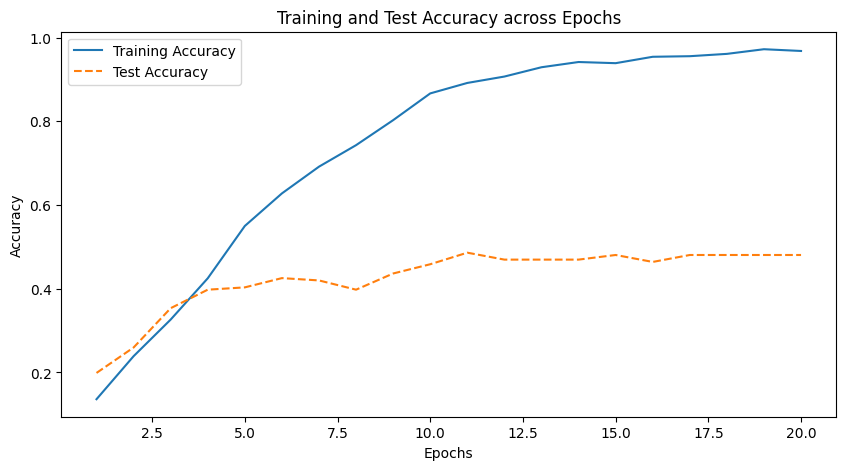

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
print(f"Initial size: {len(df)}")

df_cleaned = df.dropna(subset=['Comment Classification'])
print(f"Size after dropping NA: {len(df_cleaned)}")

# Transform multi-label to single label
df_cleaned['SingleLabel'] = df_cleaned['Comment Classification'].apply(lambda x: x[0])

# 保留在38个类别中的标签
categories = [
    "Naming Conventions", "Code Style & Formatting", "Code Complexity", "Duplication",
    "Using standard methods", "Moving Functionality", "Removing Dead Code", "Visibility",
    "Depreciated Functions", "Inline Comments", "Documentation", "Logging", "Feature Completeness",
    "Wrong Location", "Variable Initialisation", "Logic Error", "Comparison Statements",
    "Function Parameters", "Function Calls", "Unvalidated Element", "Element Type",
    "Issues with Outside Code", "Unhandled Errors/Exceptions", "Input Validation",
    "Compatibility Issues", "Security Concerns", "Algorithmic Efficiency/Performance",
    "Data & Resource Management", "Execution Time", "Network Usage", "Test Coverage",
    "Test Cases", "Test Results", "Other Test related", "Social Communication",
    "Knowledge Transfer", "Understanding", "Misc"
]

# Filter based on the frequency of categories
value_counts = df_cleaned['SingleLabel'].value_counts()
categories_to_keep = value_counts[value_counts >= 5].index.tolist()

df_cleaned = df_cleaned[df_cleaned['SingleLabel'].isin(categories_to_keep)]
print(f"Size after category filtering: {len(df_cleaned)}")

# Map the labels to their corresponding IDs
categories = sorted(categories_to_keep)
label_map = {label: i for i, label in enumerate(categories)}
df_cleaned['SingleLabelID'] = df_cleaned['SingleLabel'].map(label_map)

print(df_cleaned.shape)

# Now, split the dataset
if not df_cleaned.empty:
    X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
        df_cleaned['Comment Body'], df_cleaned['SingleLabelID'], test_size=0.2, random_state=42
    )
else:
    print("Cannot split the dataset as it's empty!")

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values).long()
test_labels = torch.tensor(y_test_cleaned.values).long()

# 3. DataLoader Preparation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a custom BERT model
class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        return loss, logits

# Set device and move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(num_labels=len(label_map))
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Learning rate scheduler
epochs = 20
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# Train the model
train_accuracies = []
test_accuracies = []  # Store test accuracies
for epoch in range(epochs):
    model.train()
    total_loss = 0
    predictions_train = []
    true_labels_train = []
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        model.zero_grad()
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits_train = logits.argmax(dim=1).detach().cpu().numpy()
        predictions_train.extend(logits_train)
        true_labels_train.extend(labels.cpu().numpy())
        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})

    train_accuracy = accuracy_score(true_labels_train, predictions_train)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    model.eval()
    predictions_test = []
    true_labels_test = []
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            _, logits = model(input_ids, attention_mask=attention_mask)
        logits_test = logits.argmax(dim=1).detach().cpu().numpy()
        predictions_test.extend(logits_test)
        true_labels_test.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(true_labels_test, predictions_test)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1} - Training loss: {total_loss/len(train_dataloader):.3f}, Training accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy across Epochs")
plt.legend()
plt.show()

In [ ]:
print(df_cleaned.shape)

(0, 8)


In [ ]:
print(label_map)


{'R': 0, 'C': 1, 'V': 2, 'M': 3, 'K': 4, 'S': 5, 'U': 6, 'N': 7, 'L': 8, 'D': 9, 'I': 10, 'E': 11, 'F': 12, 'W': 13, 'O': 14, 'A': 15, 'T': 16}


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# 1. 数据加载
df = pd.read_json("HAO_comment_classification.json")
df_cleaned = df.dropna(subset=['Comment Classification'])
df_cleaned['SingleLabel'] = df_cleaned['Comment Classification'].apply(lambda x: x[0])

label_map = {label: i for i, label in enumerate(df_cleaned['SingleLabel'].unique())}
df_cleaned['SingleLabelID'] = df_cleaned['SingleLabel'].map(label_map)

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    df_cleaned['Comment Body'], df_cleaned['SingleLabelID'], test_size=0.2, random_state=42
)

# 2. 使用BERT的tokenizer进行tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(texts, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(X_train_cleaned)
test_input_ids, test_attention_masks = tokenize_data(X_test_cleaned)
train_labels = torch.tensor(y_train_cleaned.values).long()
test_labels = torch.tensor(y_test_cleaned.values).long()

# 3. DataLoader Preparation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Custom Model Preparation with additional Fully Connected Layers
class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        return loss, logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(num_labels=len(label_map))
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Add learning rate scheduler
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# 5. Model Training
train_accuracies = []
test_accuracies = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_loss += loss.item()

        # Calculate training accuracy
        preds = torch.argmax(logits, dim=1).flatten()
        correct_train_preds += (preds == labels).cpu().numpy().sum()
        total_train_preds += len(labels)

        loss.backward()
        optimizer.step()

        # Update learning rate
        scheduler.step()

        progress_bar.set_postfix({'loss': total_loss / (epoch + 1)})

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_train_preds / total_train_preds
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1} - Training loss: {avg_train_loss:.3f}, Training Accuracy: {train_accuracy:.2f}")

# 6. Model Evaluation
model.eval()
predictions = []
correct_test_preds = 0
total_test_preds = 0
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
    preds = torch.argmax(logits, dim=1).flatten()
    predictions.extend(preds.cpu().numpy())
    correct_test_preds += (preds == labels).cpu().numpy().sum()
    total_test_preds += len(labels)

test_accuracy = correct_test_preds / total_test_preds
test_accuracies.append(test_accuracy)

# 7. Compute Metrics
true_labels_flat = y_test_cleaned.values
print("Classification Report:")
print(classification_report(true_labels_flat, predictions, target_names=label_map.keys()))

print(f"Train Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 46/46 [00:28<00:00,  1.60it/s, loss=120]


Epoch 1 - Training loss: 2.599, Training Accuracy: 0.18


Epoch 2: 100%|██████████| 46/46 [00:29<00:00,  1.55it/s, loss=54.1]


Epoch 2 - Training loss: 2.353, Training Accuracy: 0.28


Epoch 3: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=33.4]


Epoch 3 - Training loss: 2.177, Training Accuracy: 0.32


Epoch 4: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=23.2]


Epoch 4 - Training loss: 2.020, Training Accuracy: 0.42


Epoch 5: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=16.6]


Epoch 5 - Training loss: 1.808, Training Accuracy: 0.51


Epoch 6: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=12.2]


Epoch 6 - Training loss: 1.596, Training Accuracy: 0.57


Epoch 7: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s, loss=9.34]


Epoch 7 - Training loss: 1.421, Training Accuracy: 0.64


Epoch 8: 100%|██████████| 46/46 [00:30<00:00,  1.48it/s, loss=7.4]


Epoch 8 - Training loss: 1.287, Training Accuracy: 0.68


Epoch 9: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=6.22]


Epoch 9 - Training loss: 1.217, Training Accuracy: 0.70


Epoch 10: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s, loss=5.24]


Epoch 10 - Training loss: 1.140, Training Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           R       0.00      0.00      0.00         8
           C       0.45      0.62      0.52        37
           V       0.00      0.00      0.00         2
           M       1.00      0.11      0.20         9
           K       0.00      0.00      0.00         4
           S       0.00      0.00      0.00         6
           U       0.47      0.67      0.55        36
           N       0.69      0.58      0.63        19
           L       0.64      0.47      0.54        15
           D       0.33      0.64      0.44        25
           I       0.00      0.00      0.00         5
           E       0.00      0.00      0.00         3
           F       0.00      0.00      0.00         3
           W       0.00      0.00      0.00         1
           O       0.00      0.00      0.00         2
           A       0.00      0.00      0.00         1
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
